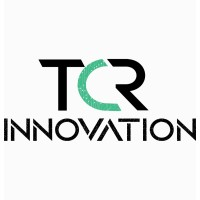

# TECHNICAL CODING RESEARCH INNOVATION 

## ARTIFICIAL INTELLIGENCE INTERNSHIP[April 2022] 

### Author : Ashwin Chaudhari

# Project Topic : Entity Determination  In The   Food Delivery Data Using  spaCy's NER 


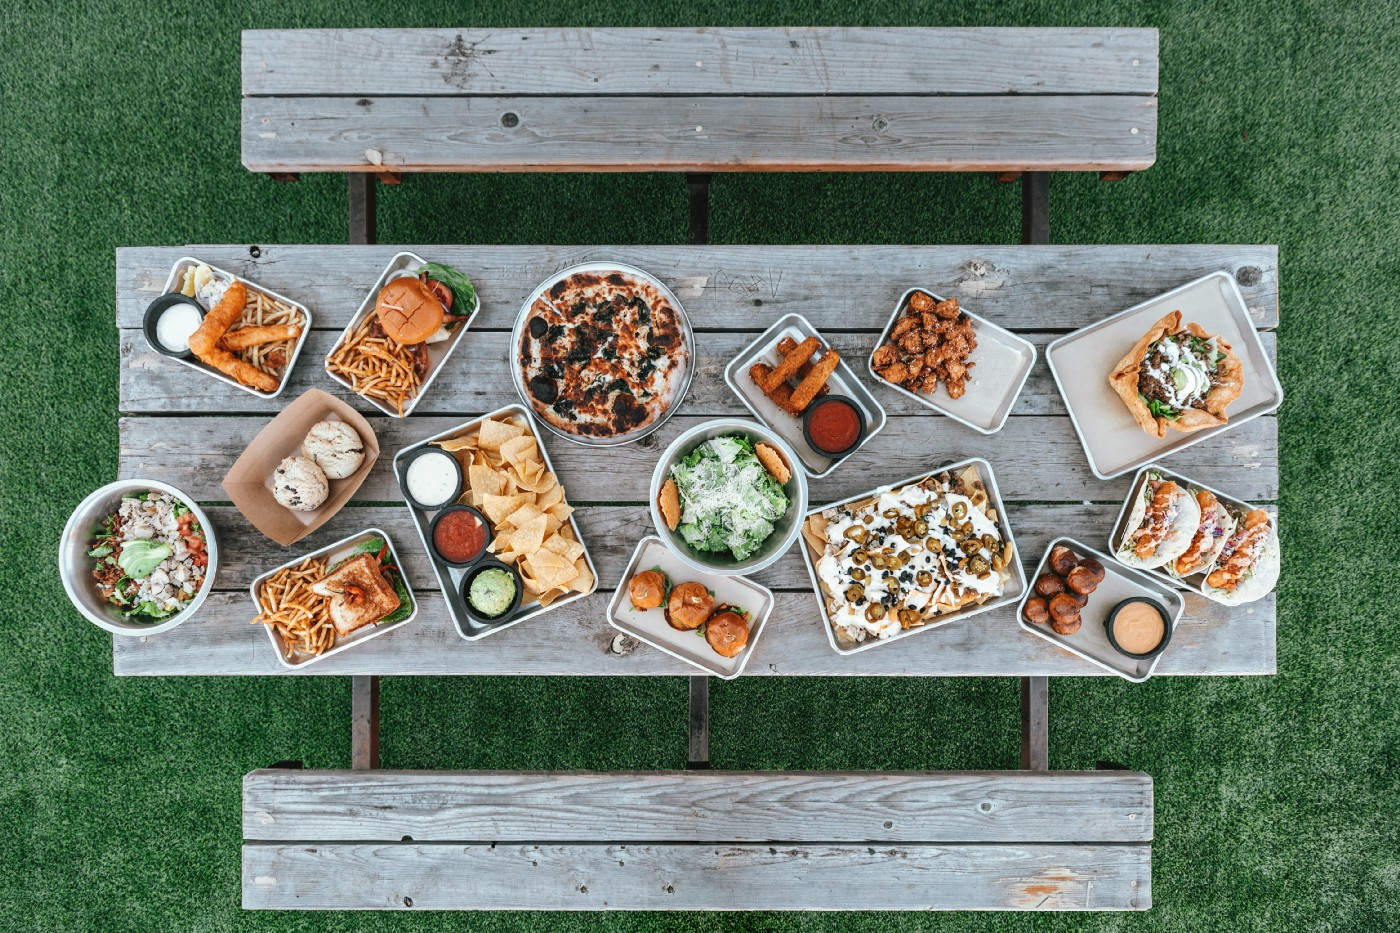

In this notebook, we'll be training spaCy to identify `FOOD` entities from a body of text - a task known as named-entity recognition (NER). If all goes well, we should be able to identify the foods from the following sentences:

- I decided to have `chocolate ice cream` as a little treat for myself.
- I had a `hamburger` and `chips` for lunch today.
- I ordered `basmati rice`, `leaf spinach` and `cheese` from Tesco yesterday.

spaCy has a NER accuracy of [85.85%](https://spacy.io/usage/facts-figures), so something in that range would be nice for our `FOOD` entities. 

#### Approach
We'll use the following approach:

1. Generate sentences with `FOOD` entities.
2. Generate sentences with **existing** [spaCy entities](https://spacy.io/usage/linguistic-features#named-entities) to avoid the [catastrophic forgetting](https://explosion.ai/blog/pseudo-rehearsal-catastrophic-forgetting) problem.
3. Train spaCy NER with the existing entities and the custom `FOOD` entities. Stir until good enough.

#### Results

Category | Results
---|---------
`FOOD` Entities | 94.14%
Existing Entities | 71.32%

<br>

See the Evaluation and Results section for a full breakdown.

In [ ]:
# download spacy language model
!python -m spacy download en_core_web_lg

     |████████████████████████▎       | 594.1 MB 113.6 MB/s eta 0:00:02IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

     |████████████████████████████████| 782.7 MB 132.5 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.3.1-py3-none-any.whl size=782936123 sha256=a2476b400043b49b30186fa1890ae79192b1d461ba0bed048e3d10d91b4b2475
  Stored in directory: /tmp/pip-ephem-wheel-cache-24xczx7i/wheels/41/75/77/c4a98e18b2c317a2a13931cbbea7e3ca7f3a21efc36adc1d71
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


## Importing Important Libraries

In [ ]:
# import libraries
import en_core_web_lg
import pandas as pd
import re
import random
import spacy
from spacy.util import minibatch, compounding
import warnings
import matplotlib.pyplot as plt

## Generating Food Data

We'll be using food data from the USDA's [Branded Food's dataset](https://fdc.nal.usda.gov/download-datasets.html).

### Preparing the food data

In [ ]:
# read in the food csv file
food_df = pd.read_csv("food.csv")

# print row and column information
food_df.head()

,fdc_id,data_type,description,food_category_id,publication_date
0,356425,branded_food,MOCHI ICE CREAM BONBONS,NaN,2019-04-01
1,356426,branded_food,CHIPOTLE BARBECUE SAUCE,NaN,2019-04-01
2,356427,branded_food,HOT & SPICY BARBECUE SAUCE,NaN,2019-04-01
3,356428,branded_food,BARBECUE SAUCE,NaN,2019-04-01
4,356429,branded_food,BARBECUE SAUCE,NaN,2019-04-01


You can see that the `description` column has the names for the foods we're interested in.

In [ ]:
# print the size 
food_df["description"].size

354565

We have way more rows than we need, so let's:
- Disqualify foods with special characters (`+`,`&`, `!`, `,` and so on).
- Filter out foods containing more than 3 words.

In [ ]:
# diaqualify foods with special characters, lowercase and extract results from "description" column
foods = food_df[food_df["description"].str.contains("[^a-zA-Z ]") == False]["description"].apply(lambda food: food.lower())

# filter out foods with more than 3 words, drop any duplicates
foods = foods[foods.str.split().apply(len) <= 3].drop_duplicates()

# print the remaining size
foods.size

37596

Now, we need to think about how we want our data to be distributed. By reducing to 3-worded food items, we effectively have food entities that look like this:

- `hamburger` | 1-worded
- `grilled cheese` | 2-worded
- `chocolate ice cream` | 3-worded

When feeding our training data into spaCy, we want to think about the bias we want spaCy to avoid. 

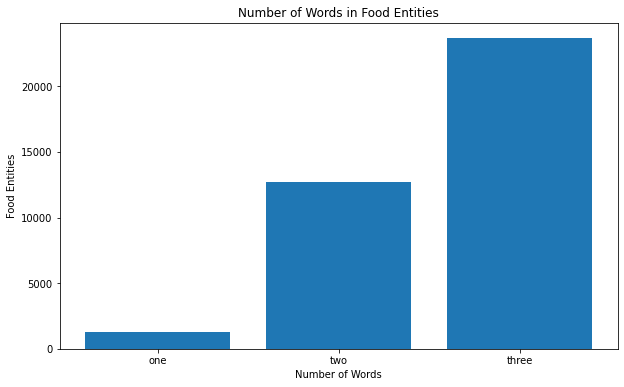

In [ ]:
# find one-worded, two-worded and three-worded foods
one_worded_foods = foods[foods.str.split().apply(len) == 1]
two_worded_foods = foods[foods.str.split().apply(len) == 2]
three_worded_foods = foods[foods.str.split().apply(len) == 3]

# create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([1, 2, 3], [one_worded_foods.size, two_worded_foods.size, three_worded_foods.size])

# label the x-axis instances
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(["one", "two", "three"])

# set the title and the xy-axis labels
plt.title("Number of Words in Food Entities")
plt.xlabel("Number of Words")
plt.ylabel("Food Entities")

# display the plot
plt.show()

Because the majority of our food entities are multi-worded, spaCy would develop a bias for multi-worded foods. If we look back to our example 
of `grilled cheese`, it's not a big deal if spaCy identifies `cheese` instead of `grilled cheese`. It is a big deal if spaCy fails to identify `cheese` at all.

*As an aside, I ran this experiment, and spaCy only had a 10% accuracy for classifying single-worded `FOOD` entities, failing with foods such as `hamburger` and `cheese`.*

So let's filter the dataset further, such that **45%** are one-worded foods, **30%** are two-worded foods, and **25%** are three-worded foods.

In [ ]:
# total number of foods
total_num_foods = round(one_worded_foods.size / 45 * 100)

# shuffle the 2-worded and 3-worded foods since we'll be slicing them
two_worded_foods = two_worded_foods.sample(frac=1)
three_worded_foods = three_worded_foods.sample(frac=1)

# append the foods together 
foods = one_worded_foods.append(two_worded_foods[:round(total_num_foods * 0.30)]).append(three_worded_foods[:round(total_num_foods * 0.25)])

# print the resulting sizes
for i in range(3):
    print(f"{i+1}-worded food entities:", foods[foods.str.split().apply(len) == i + 1].size)

1-worded food entities: 1258
2-worded food entities: 839
3-worded food entities: 699


### Split train and test food data
At this point, we want to create different placeholders that we can insert our food entities into. 

In [ ]:
food_templates = [
    "I ate my {}",
    "I'm eating a {}",
    "I just ate a {}",
    "I only ate the {}",
    "I'm done eating a {}",
    "I've already eaten a {}",
    "I just finished my {}",
    "When I was having lunch I ate a {}",
    "I had a {} and a {} today",
    "I ate a {} and a {} for lunch",
    "I made a {} and {} for lunch",
    "I ate {} and {}",
    "today I ate a {} and a {} for lunch",
    "I had {} with my husband last night",
    "I brought you some {} on my birthday",
    "I made {} for yesterday's dinner",
    "last night, a {} was sent to me with {}",
    "I had {} yesterday and I'd like to eat it anyway",
    "I ate a couple of {} last night",
    "I had some {} at dinner last night",
    "Last night, I ordered some {}",
    "I made a {} last night",
    "I had a bowl of {} with {} and I wanted to go to the mall today",
    "I brought a basket of {} for breakfast this morning",
    "I had a bowl of {}",
    "I ate a {} with {} in the morning",
    "I made a bowl of {} for my breakfast",
    "There's {} for breakfast in the bowl this morning",
    "This morning, I made a bowl of {}",
    "I decided to have some {} as a little bonus",
    "I decided to enjoy some {}",
    "I've decided to have some {} for dessert",
    "I had a {}, a {} and {} at home",
    "I took a {}, {} and {} on the weekend",
    "I ate a {} with {} and {} just now",
    "Last night, I ate an {} with {} and {}",
    "I tasted some {}, {} and {} at the office",
    "There's a basket of {}, {} and {} that I consumed",
    "I devoured a {}, {} and {}",
    "I've already had a bag of {}, {} and {} from the fridge"
]

We'll break up our food sentences (which contain our entities) into a training set and a test set. We also need the data to be in a specific format for training:
```
data = [
    ("I love chicken", [(8, 13, "FOOD")]),
    ... 
]
```

In [ ]:
# create dictionaries to store the generated food combinations. Do note that one_food != one_worded_food. one_food == "barbecue sauce", one_worded_food == "sauce"
TRAIN_FOOD_DATA = {
    "one_food": [],
    "two_foods": [],
    "three_foods": []
}

TEST_FOOD_DATA = {
    "one_food": [],
    "two_foods": [],
    "three_foods": []
}

# one_food, two_food, and three_food combinations will be limited to 167 sentences
FOOD_SENTENCE_LIMIT = 167

# helper function for deciding what dictionary and subsequent array to append the food sentence on to
def get_food_data(count):
    return {
        1: TRAIN_FOOD_DATA["one_food"] if len(TRAIN_FOOD_DATA["one_food"]) < FOOD_SENTENCE_LIMIT else TEST_FOOD_DATA["one_food"],
        2: TRAIN_FOOD_DATA["two_foods"] if len(TRAIN_FOOD_DATA["two_foods"]) < FOOD_SENTENCE_LIMIT else TEST_FOOD_DATA["two_foods"],
        3: TRAIN_FOOD_DATA["three_foods"] if len(TRAIN_FOOD_DATA["three_foods"]) < FOOD_SENTENCE_LIMIT else TEST_FOOD_DATA["three_foods"],
    }[count]

# the pattern to replace from the template sentences
pattern_to_replace = "{}"

# shuffle the data before starting
foods = foods.sample(frac=1)

# the count that helps us decide when to break from the for loop
food_entity_count = foods.size - 1

# start the while loop, ensure we don't get an index out of bounds error
while food_entity_count >= 2:
    entities = []

    # pick a random food template
    sentence = food_templates[random.randint(0, len(food_templates) - 1)]

    # find out how many braces "{}" need to be replaced in the template
    matches = re.findall(pattern_to_replace, sentence)

    # for each brace, replace with a food entity from the shuffled food data
    for match in matches:
        food = foods.iloc[food_entity_count]
        food_entity_count -= 1

        # replace the pattern, but then find the match of the food entity we just inserted
        sentence = sentence.replace(match, food, 1)
        match_span = re.search(food, sentence).span()

        # use that match to find the index positions of the food entity in the sentence, append
        entities.append((match_span[0], match_span[1], "FOOD"))

    # append the sentence and the position of the entities to the correct dictionary and array
    get_food_data(len(matches)).append((sentence, {"entities": entities}))

In [ ]:
# print the number of food sentences, as well as an example sentence
for key in TRAIN_FOOD_DATA:
    print("{} {} sentences: {}".format(len(TRAIN_FOOD_DATA[key]), key, TRAIN_FOOD_DATA[key][0]))

167 one_food sentences: ('Last night, I ordered some bueno', {'entities': [(27, 32, 'FOOD')]})
167 two_foods sentences: ('I ate a tokyo style ramen and a bunuelos dessert for lunch', {'entities': [(8, 25, 'FOOD'), (32, 48, 'FOOD')]})
167 three_foods sentences: ('Last night, I ate an edam with strawberry lozenges and springhill strawberry jam', {'entities': [(21, 25, 'FOOD'), (31, 50, 'FOOD'), (55, 80, 'FOOD')]})


Nice, we now have ~500 training sentences, with each sentence either containing 1, 2, or 3 `FOOD` entities.

In [ ]:
for key in TEST_FOOD_DATA:
    print("{} {} items: {}".format(len(TEST_FOOD_DATA[key]), key, TEST_FOOD_DATA[key][0]))

876 one_food items: ("I've already eaten a eggnog", {'entities': [(21, 27, 'FOOD')]})
191 two_foods items: ('I made a deli chicken salad and organic nutrition bar for lunch', {'entities': [(9, 27, 'FOOD'), (32, 53, 'FOOD')]})
178 three_foods items: ("There's a basket of tahinibar, gumballs and smoothies that I consumed", {'entities': [(20, 29, 'FOOD'), (31, 39, 'FOOD'), (44, 53, 'FOOD')]})


We also have plenty of test data. Doesn't matter too much that it's not evenly distributed.

## Generating Revision Data

As mentioned in the overview, we also need to generate sentences that contain spaCy entities. 
This helps us avoid the situation where the NER model is able to identify the `FOOD` entities, but [forgets](https://explosion.ai/blog/pseudo-rehearsal-catastrophic-forgetting) how to classify entities like `ORG` or `PERSON`.

While `ORG` or `PERSON` isn't important for nutrition-tracking, other entities like `QUANTITY` and `CARDINAL` will help us associate foods with their quantities later on:

- I ate `two` `slices of toast`.

### Preparing the revision data


In [ ]:
# read in the revision data (just used a random article dataset from a different course I had taken)
npr_df = pd.read_csv("npr.csv")
ER
# print row and column information
npr_df.head()

,Article
0,"In the Washington of 2016, even when the polic..."
1,Donald Trump has used Twitter — his prefe...
2,Donald Trump is unabashedly praising Russian...
3,"Updated at 2:50 p. m. ET, Russian President Vl..."
4,"From photography, illustration and video, to d..."


We'll keep sentences of a similar length to our generated food sentences.

In [ ]:
# create an nlp object as we'll use this to seperate the sentences and identify existing entities
nlp = en_core_web_lg.load()

In [ ]:
revision_texts = []

# convert the articles to spacy objects to better identify the sentences. Disabled unneeded components. # takes ~ 4 minutes
for doc in nlp.pipe(npr_df["Article"][:6000], batch_size=30, disable=["tagger", "ner"]):
    for sentence in doc.sents:
        if  40 < len(sentence.text) < 80:
            # some of the sentences had excessive whitespace in between words, so we're trimming that
            revision_texts.append(" ".join(re.split("\s+", sentence.text, flags=re.UNICODE)))

In [ ]:
revisions = []

# Use the existing spaCy model to predict the entities, then append them to revision
for doc in nlp.pipe(revision_texts, batch_size=50, disable=["tagger", "parser"]):
    
    # don't append sentences that have no entities
    if len(doc.ents) > 0:
        revisions.append((doc.text, {"entities": [(e.start_char, e.end_char, e.label_) for e in doc.ents]}))

### Split train and test revision data
In the previous step we filtered out sentences that were too short and too long. We've also used spaCy to predict the entities from the filtered sentences.

In [ ]:
# print an example of the revision sentence
print(revisions[0][0])

# print an example of the revision data
print(revisions[0][1])

And in that sense, this year shows little sign of ending on Dec. 31.
{'entities': [(19, 28, 'DATE'), (60, 67, 'DATE')]}


When splitting the train and test data, we'll ensure that the revision training data has at least 100 examples of the different entity types.

In [ ]:
# create arrays to store the revision data
TRAIN_REVISION_DATA = []
TEST_REVISION_DATA = []

# create dictionaries to keep count of the different entities
TRAIN_ENTITY_COUNTER = {}
TEST_ENTITY_COUNTER = {}

# This will help distribute the entities (i.e. we don't want 1000 PERSON entities, but only 80 ORG entities)
REVISION_SENTENCE_SOFT_LIMIT = 100

# helper function for incrementing the revision counters
def increment_revision_counters(entity_counter, entities):
    for entity in entities:
        label = entity[2]
        if label in entity_counter:
            entity_counter[label] += 1
        else:
            entity_counter[label] = 1

random.shuffle(revisions)
for revision in revisions:
    # get the entities from the revision sentence
    entities = revision[1]["entities"]

    # simple hack to make sure spaCy entities don't get too one-sided
    should_append_to_train_counter = 0
    for _, _, label in entities:
        if label in TRAIN_ENTITY_COUNTER and TRAIN_ENTITY_COUNTER[label] > REVISION_SENTENCE_SOFT_LIMIT:
            should_append_to_train_counter -= 1
        else:
            should_append_to_train_counter += 1

    # simple switch for deciding whether to append to train data or test data
    if should_append_to_train_counter >= 0:
        TRAIN_REVISION_DATA.append(revision)
        increment_revision_counters(TRAIN_ENTITY_COUNTER, entities)
    else:
        TEST_REVISION_DATA.append(revision)
        increment_revision_counters(TEST_ENTITY_COUNTER, entities)

Here are the entities and their counts that were captured in our revision training sentences:

In [ ]:
TRAIN_ENTITY_COUNTER

{'DATE': 212,
 'GPE': 164,
 'CARDINAL': 195,
 'PERSON': 254,
 'LANGUAGE': 85,
 'ORG': 192,
 'WORK_OF_ART': 103,
 'TIME': 108,
 'ORDINAL': 110,
 'PERCENT': 101,
 'NORP': 115,
 'LOC': 106,
 'MONEY': 102,
 'QUANTITY': 101,
 'EVENT': 101,
 'PRODUCT': 101,
 'LAW': 95,
 'FAC': 101}

Here are the entities and counts captured in our revision test sentences. This just shows that our initial sentences had a large number of examples for `PERSON` but very few for `LAW`.

In [ ]:
TEST_ENTITY_COUNTER

{'PERSON': 14027,
 'ORG': 10360,
 'DATE': 7153,
 'GPE': 5661,
 'NORP': 2739,
 'CARDINAL': 5397,
 'QUANTITY': 171,
 'PERCENT': 441,
 'TIME': 794,
 'FAC': 152,
 'LOC': 559,
 'ORDINAL': 1151,
 'MONEY': 560,
 'WORK_OF_ART': 592,
 'PRODUCT': 119,
 'EVENT': 104,
 'LANGUAGE': 24,
 'LAW': 12}

## Training the NER Model

For every food sentence, I have revision sentences. I haven't actually seen guidance on what this should be, so this is one of those "stir until good enough" moments.

In [ ]:
# combine the food training data
TRAIN_FOOD_DATA_COMBINED = TRAIN_FOOD_DATA["one_food"] + TRAIN_FOOD_DATA["two_foods"] + TRAIN_FOOD_DATA["three_foods"]

# print the length of the food training data
print("FOOD", len(TRAIN_FOOD_DATA_COMBINED))

# print the length of the revision training data
print("REVISION", len(TRAIN_REVISION_DATA))

# join and print the combined length
TRAIN_DATA = TRAIN_REVISION_DATA + TRAIN_FOOD_DATA_COMBINED
print("COMBINED", len(TRAIN_DATA))

FOOD 501
REVISION 1490
COMBINED 1991


In [ ]:
# add NER to the pipeline and the new label
ner = nlp.get_pipe("ner")
ner.add_label("FOOD")

# get the names of the components we want to disable during training
pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

# start the training loop, only training NER
epochs = 30
optimizer = nlp.resume_training()
with nlp.disable_pipes(*other_pipes), warnings.catch_warnings():
    warnings.filterwarnings("once", category=UserWarning, module='spacy')
    sizes = compounding(1.0, 4.0, 1.001)
    
    # batch up the examples using spaCy's minibatc
    for epoch in range(epochs):
        examples = TRAIN_DATA
        random.shuffle(examples)
        batches = minibatch(examples, size=sizes)
        losses = {}
        
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, sgd=optimizer, drop=0.35, losses=losses)

        print("Losses ({}/{})".format(epoch + 1, epochs), losses)

Losses (1/30) {'ner': 16073.626560282552}
Losses (2/30) {'ner': 14584.542186669307}
Losses (3/30) {'ner': 14548.422105267644}
Losses (4/30) {'ner': 14300.272813861375}
Losses (5/30) {'ner': 14186.099578664172}
Losses (6/30) {'ner': 14101.325425518793}
Losses (7/30) {'ner': 14000.43209932954}
Losses (8/30) {'ner': 13994.203212552093}
Losses (9/30) {'ner': 14022.144056472462}
Losses (10/30) {'ner': 13901.634234594181}
Losses (11/30) {'ner': 13745.580805012956}
Losses (12/30) {'ner': 13903.877741001314}
Losses (13/30) {'ner': 13817.979523293063}
Losses (14/30) {'ner': 13830.568540076929}
Losses (15/30) {'ner': 13860.916276267613}
Losses (16/30) {'ner': 13778.726491773035}
Losses (17/30) {'ner': 13602.03644076937}
Losses (18/30) {'ner': 13822.509093627625}
Losses (19/30) {'ner': 13501.720368203663}
Losses (20/30) {'ner': 13691.972102675238}
Losses (21/30) {'ner': 13686.256363266613}
Losses (22/30) {'ner': 13478.341214498476}
Losses (23/30) {'ner': 13622.263516337844}
Losses (24/30) {'ner':

## Evaluating the Model


In [ ]:
# display sentence involving original entities
spacy.displacy.render(nlp("Apple is looking at buying U.K. startup for $1 billion"), style="ent")

In [ ]:
# display sentences involving target entity
spacy.displacy.render(nlp("I had a hamburger and chips for lunch today."), style="ent")
spacy.displacy.render(nlp("I decided to have chocolate ice cream as a little treat for myself."), style="ent")
spacy.displacy.render(nlp("I ordered basmati rice, leaf spinach and cheese from Tesco yesterday"), style="ent")

Initial results seem pretty good, let's evaluate on a wider scale.

### Evaluating Food Entities

In [ ]:
# dictionary to hold our evaluation data
food_evaluation = {
    "one_food": {
        "correct": 0,
        "total": 0,
    },
    "two_foods": {
        "correct": 0,
        "total": 0
    },
    "three_foods": {
        "correct": 0,
        "total": 0
    }
}

word_evaluation = {
    "1_worded_foods": {
        "correct": 0,
        "total": 0
    },
    "2_worded_foods": {
        "correct": 0,
        "total": 0
    },
    "3_worded_foods": {
        "correct": 0,
        "total": 0
    }
}

# loop over data from our test food set (3 keys in total)
for key in TEST_FOOD_DATA:
    foods = TEST_FOOD_DATA[key]

    for food in foods:
        # extract the sentence and correct food entities according to our test data
        sentence = food[0]
        entities = food[1]["entities"]

        # for each entity, use our updated model to make a prediction on the sentence
        for entity in entities:
            doc = nlp(sentence)
            correct_text = sentence[entity[0]:entity[1]]
            n_worded_food =  len(correct_text.split())

            # if we find that there's a match for predicted entity and predicted text, increment correct counters
            for ent in doc.ents:
                if ent.label_ == entity[2] and ent.text == correct_text:
                    food_evaluation[key]["correct"] += 1
                    if n_worded_food > 0:
                        word_evaluation[f"{n_worded_food}_worded_foods"]["correct"] += 1
                    
                    # this break is important, ensures that we're not double counting on a correct match
                    break
            
            #  increment total counters after each entity loop
            food_evaluation[key]["total"] += 1
            if n_worded_food > 0:
                word_evaluation[f"{n_worded_food}_worded_foods"]["total"] += 1

In [ ]:
for key in word_evaluation:
    correct = word_evaluation[key]["correct"]
    total = word_evaluation[key]["total"]

    print(f"{key}: {correct / total * 100:.2f}%")

food_total_sum = 0
food_correct_sum = 0

print("---")
for key in food_evaluation:
    correct = food_evaluation[key]["correct"]
    total = food_evaluation[key]["total"]
    
    food_total_sum += total
    food_correct_sum += correct

    print(f"{key}: {correct / total * 100:.2f}%")

print(f"\nTotal: {food_correct_sum/food_total_sum * 100:.2f}%")

1_worded_foods: 91.10%
2_worded_foods: 96.69%
3_worded_foods: 96.88%
---
one_food: 91.44%
two_foods: 94.76%
three_foods: 98.13%

Total: 94.14%


These results are really positive. We're stumbling with `1_worded_foods` accuracy, though that's potentially because we had more testing data for `1_worded_foods`. 
Perhaps with more test examples for `2_worded_foods` and `three_worded_foods`, we'd also see that accuracy trend to ~91%.

### Evaluating Existing Entities

In [ ]:
# dictionary which will be populated with the entities and result information
entity_evaluation = {}

# helper function to udpate the entity_evaluation dictionary
def update_results(entity, metric):
    if entity not in entity_evaluation:
        entity_evaluation[entity] = {"correct": 0, "total": 0}
    
    entity_evaluation[entity][metric] += 1

# same as before, see if entities from test set match what spaCy currently predicts
for data in TEST_REVISION_DATA:
    sentence = data[0]
    entities = data[1]["entities"]

    for entity in entities:
        doc = nlp(sentence)
        correct_text = sentence[entity[0]:entity[1]]

        for ent in doc.ents:
            if ent.label_ == entity[2] and ent.text == correct_text:
                update_results(ent.label_, "correct")
                break

        update_results(entity[2], "total")


In [ ]:
sum_total = 0
sum_correct = 0

for entity in entity_evaluation:
    total = entity_evaluation[entity]["total"]
    correct = entity_evaluation[entity]["correct"]

    sum_total += total
    sum_correct += correct
    
    print("{} | {:.2f}%".format(entity, correct / total * 100))

print()
print("Overall accuracy: {:.2f}%".format(sum_correct / sum_total * 100))

PERSON | 80.18%
ORG | 50.84%
DATE | 68.61%
GPE | 82.56%
NORP | 83.61%
CARDINAL | 70.11%
QUANTITY | 79.53%
PERCENT | 88.44%
TIME | 50.88%
FAC | 56.58%
LOC | 68.69%
ORDINAL | 94.53%
MONEY | 84.11%
WORK_OF_ART | 58.78%
PRODUCT | 42.86%
EVENT | 63.46%
LANGUAGE | 91.67%
LAW | 75.00%

Overall accuracy: 71.23%


These results are a little harder to interpret. After all, we're testing entities that the original spaCy model predicited for us. 
Those predicted entities may well be **wrong** since spaCy's accuracy is at around 86%. If 14% of the entities we're using to verify the accuracy of our new model are wrong, then where does that leave us?

A better comparison would be to load in spaCy's original model and use that to predict against this test set and compare that accuracy  **%** to this one of **71%**. 
We could then use that as a benchmark for measuring how introducing `FOOD` entities deteriorates our model.



## Saving the model

In [ ]:
nlp.meta["name"] = "food_entity_extractor_v2"
nlp.to_disk("./models/v2")

## Results

The results we arrived at is the following for our `FOOD` entities:

Category | Results
---|---------
One-worded foods | 91.10%
Two-worded foods | 96.69%
Three-worded foods | 96.88%
Sentences with one food | 91.44%
Sentences with two foods | 94.76%
Sentences with three foods | 96.88%
**Overall accuracy** | **94.14%**

<br>

The results for our existing entities:

Category | Results
---|---------
`PERSON` | 80.18%
`ORG` | 50.84%
`DATE` | 68.61%
`GPE` | 82.56%
`NORP` | 83.61%
`CARDINAL` | 70.11%
`QUANTITY` | 79.53%
`PERCENT` | 88.44%
`TIME` | 50.88%
`FAC` | 56.58%
`LOC` | 68.69%
`ORDINAL` | 94.53%
`MONEY` | 84.11%
`WORK_OF_ART` | 58.78%
`PRODUCT` | 42.86%
`EVENT` | 63.46%
`LANGUAGE` | 91.67%
`LAW` | 75.00%
**Overall accuracy** | **71.32%**

<br>

I'm pretty happy with the accuracy of the `FOOD` entities, though it'd be worthwhile increasing the test sentences. 
For the revision entities, I'll first need to test this the accuracy with spaCy's original language model. If the results are still poor,
I'll experiment with different revision datasets and adjust the ratio of food:revision sentences. 
